<a href="https://colab.research.google.com/github/HungHoangDinh/diffuser/blob/main/Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [1]:
%pip install -Uq diffusers ftfy accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.3 MB/s eta 0:00:00


In [2]:
# Installing transformers from source for now since we need the latest version for Depth2Img
%pip install -Uq git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionDepth2ImgPipeline
    )

# We'll use a couple of demo images later in the notebook
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

img_height = 512
img_width = 512

init_image = download_image(img_url).resize((img_height, img_width))
mask_image = download_image(mask_url).resize((img_height, img_width))

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [4]:
# Set device
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

# Generating Images from Text
Let’s load a Stable Diffusion pipeline and see what it can do. There are multiple different versions of Stable Diffusion, with the latest at the time of writing being version 2.1. If you’d like to explore an older version, simply replace the model ID with the appropriate model

In [5]:
# Code to log in to the Hugging Face Hub, needed for sharing models
# Make sure you use a token with WRITE access
from huggingface_hub import notebook_login

notebook_login()

In [6]:
# Load the pipeline
model_id = "Manojb/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/372 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--Manojb--stable-diffusion-2-1-base/snapshots/0094d483a120f3f33dafbd187ea4aa60d10de75c/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  0%|          | 0/35 [00:00<?, ?it/s]

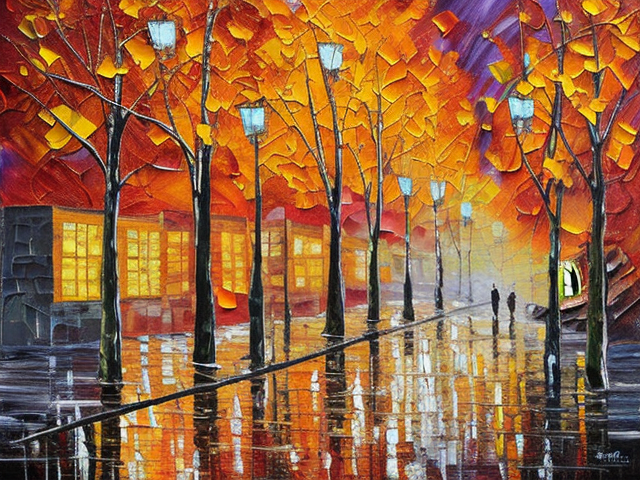

In [24]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape", # What to generate
    negative_prompt="Oversaturated, blurry, low quality", # What NOT to generate
    height=480, width=640,     # Specify the image size
    guidance_scale=8,          # How strongly to follow the prompt
    num_inference_steps=35,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image
pipe_output.images[0]

You can see the effect of increasing the guidance scale in the following cell:



  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

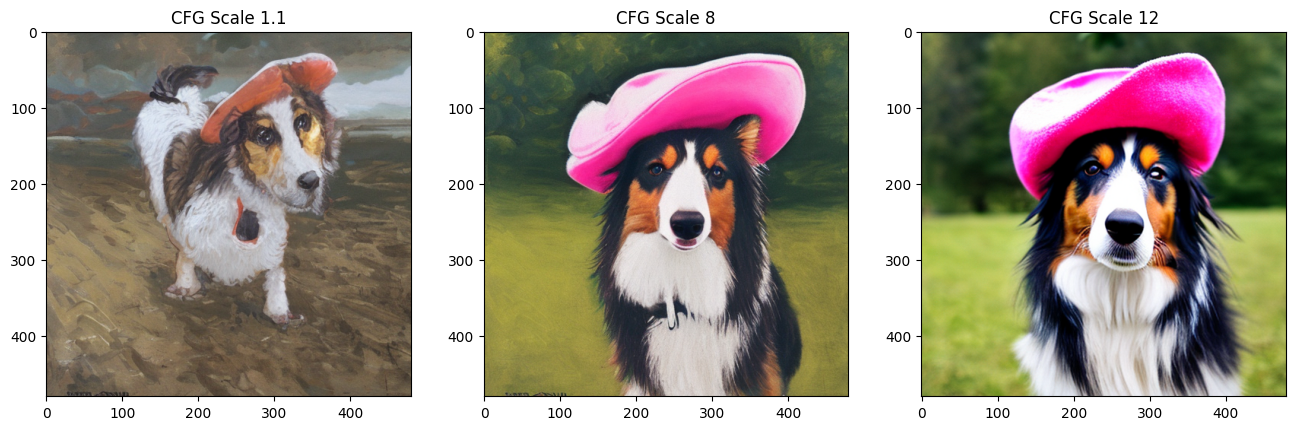

In [14]:

cfg_scales = [1.1, 8, 12]
prompt = "A collie with a pink hat"
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
  im = pipe(prompt, height=480, width=480,
    guidance_scale=cfg_scales[i], num_inference_steps=35,
    generator=torch.Generator(device=device).manual_seed(42)).images[0]
  ax.imshow(im); ax.set_title(f'CFG Scale {cfg_scales[i]}');

# Pipeline Components


In [7]:
print(list(pipe.components.keys())) # List components

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder']


To better understand how the pipeline works, let’s briefly see each component in action individually and then put them all together to replicate the functionality of the pipeline for ourselves.

# The VAE
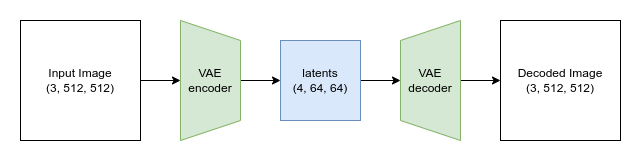

The VAE (variational autoencoder) is a type of model that can encode its input into a compressed representation and then decode this ‘latent’ representation back into something close to the original input. When generating images with Stable Diffusion, we first generate the latents by applying the diffusion process in the ‘latent space’ of the VAE, and then decode them at the end to view the resulting image.



In [8]:
# Create some fake data (a random image, range (-1, 1))
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1
print("Input images shape:", images.shape)

# Encode to latent space
with torch.no_grad():
  latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)

# Decode again
with torch.no_grad():
  decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


# The Tokenizer and Text Encoder
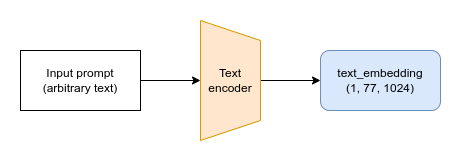

The goal of the text encoder is to turn an input string (the prompt) into a numerical representation that can be fed to the UNet as conditioning. The text is first turned into a series of tokens using the pipeline’s tokenizer. The text encoder has a vocabulary of about 50k tokens - any word isn’t in this vocabulary is split into smaller sub-words. The tokens are then fed through the text encoder model itself - a transformer model that was originally trained as the text encoder for CLIP. The hope is that this pretrained transformer model has learnt rich representations of text that will be useful for the diffusion task too.

In [9]:
# Tokenizing and encoding an example prompt manually

# Tokenize
input_ids = pipe.tokenizer(["A painting of a flooble"])['input_ids']
print("Input ID -> decoded token")
for input_id in input_ids[0]:
  print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

# Feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
  text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
print("Text embeddings shape:", text_embeddings.shape)

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 8, 1024])


In [10]:
text_embeddings = pipe._encode_prompt("A painting of a flooble", device, 1, True, '')
text_embeddings.shape

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:313: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


torch.Size([2, 77, 1024])

## The UNet
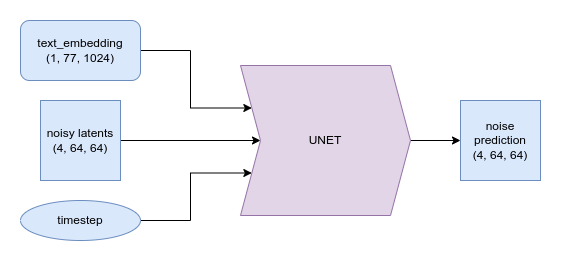

The UNet takes a noisy input and predicts the noise, just like the UNets we’ve seen in previous units. Unlike those previous examples, the input is not an image but is instead a latent representation of an image. And in addition to the timestep conditioning, this UNet also takes in the text embeddings of the prompt as an additional input. Here it is making predictions on some dummy data:

In [19]:
pipe.scheduler.set_timesteps(35)

In [20]:
# Dummy inputs
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)

# Model prediction
with torch.no_grad():
  unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print('UNet output shape:', unet_output.shape) # Same shape as the input latents

UNet output shape: torch.Size([1, 4, 64, 64])


# The Scheduler
The scheduler stores the noise schedule and manages updating the noisy sample based on the model predictions. The default scheduler is a PNDMScheduler, but you can use others (such as LMSDiscreteScheduler) as long as they are initialized with the same configuration.

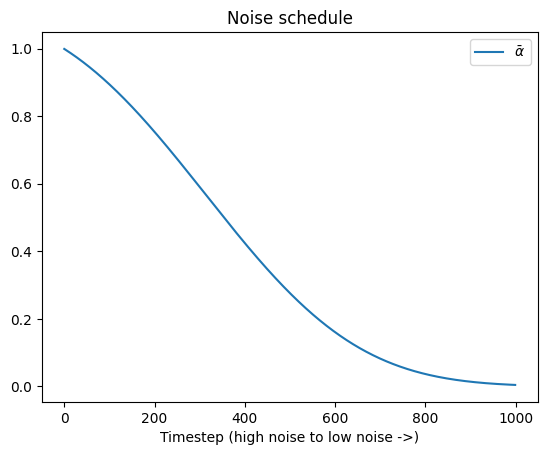

In [21]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'$\bar{\alpha}$')
plt.xlabel('Timestep (high noise to low noise ->)');
plt.title('Noise schedule');plt.legend();

If you want to try out a different scheduler, you can swap in a new one as follows:



Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.36.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_beta_sigmas": false,
  "use_exponential_sigmas": false,
  "use_karras_sigmas": false
}



  0%|          | 0/50 [00:00<?, ?it/s]

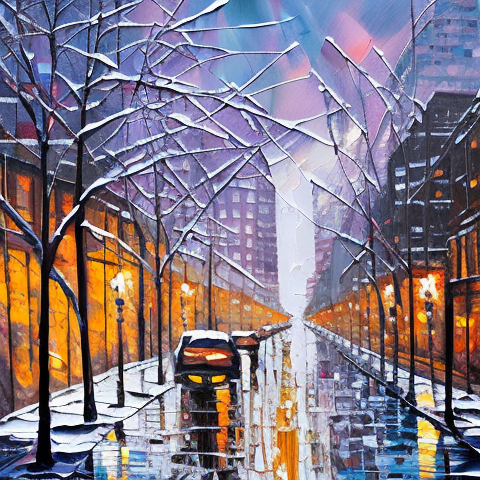

In [22]:
from diffusers import LMSDiscreteScheduler

# Replace the scheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

# Print the config
print('Scheduler config:', pipe.scheduler)

# Generate an image with this new scheduler
pipe(prompt="Palette knife painting of an winter cityscape", height=480, width=480,
     generator=torch.Generator(device=device).manual_seed(42)).images[0]

# A DIY Sampling Loop
Now that we’ve seen all these components in action, we can put them together to replicate the functionality of the pipeline:

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:599: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


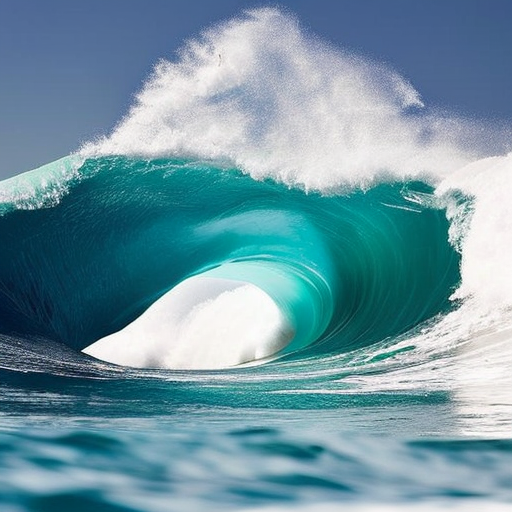

In [25]:
guidance_scale = 8
num_inference_steps = 30
prompt = "Beautiful picture of a wave breaking"
negative_prompt = "zoomed in, blurry, oversaturated, warped"

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Loop through the sampling timesteps
for i, t in enumerate(pipe.scheduler.timesteps):

  # Expand the latents if we are doing classifier free guidance
  latent_model_input = torch.cat([latents] * 2)

  # Apply any scaling required by the scheduler
  latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

  # Predict the noise residual with the UNet
  with torch.no_grad():
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # Perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # Compute the previous noisy sample x_t -> x_t-1
  latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode the resulting latents into an image
with torch.no_grad():
  image = pipe.decode_latents(latents.detach())

# View
pipe.numpy_to_pil(image)[0]

# Additonal Pipelines
## Img2Img - A DIY Img2Img Loop



 The Img2Img pipeline first encodes an existing image into a set of latents, then adds some noise to the latents and uses that as the starting point. The amount of noise added and the number of denoising steps applied determine the ‘strength’ of the img2img process. Adding just a small amount of noise (low strength) will result in very little change, while adding the maximum amount of noise and running the full denoising process will give an image that hardly resembles the input apart from some similarities on overall structure.

In [26]:
import numpy as np

# Encode init_image
init_image_tensor = torch.from_numpy(np.array(init_image).transpose(2, 0, 1)).float() / 255.0 # 0~255 => 0~1
init_image_tensor = 2.0 * init_image_tensor - 1.0 # 0~1 => -1~1
init_image_tensor = init_image_tensor.unsqueeze(0).to(device) # add batch dim.

with torch.no_grad():
    init_image_latents = pipe.vae.encode(init_image_tensor).latent_dist.sample() * pipe.vae.config.scaling_factor

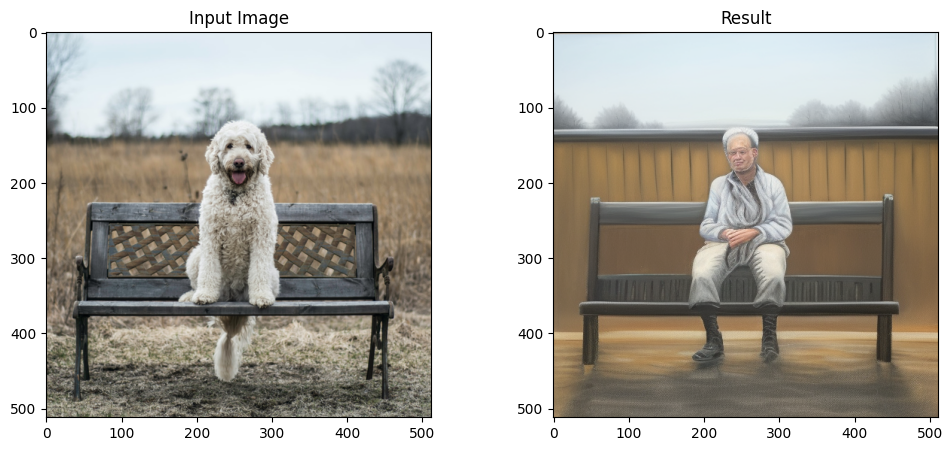

In [28]:
guidance_scale = 7.5
num_inference_steps = 30
strength = 0.6
prompt = "An oil painting of a man on a bench"
# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, '')

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Prepare latent variables
# We don't use all timesteps in the noise scheduler.
# Calculate a subset of timesteps based on `strength` to apply to the initial image.
init_timestep = min(int(num_inference_steps * strength), num_inference_steps)
t_start = max(num_inference_steps - init_timestep, 0)
timesteps = pipe.scheduler.timesteps[t_start:]
# The first timestep of the new timesteps will be the starting point for adding noise to the initial image.
latent_timestep = timesteps[:1]

# Add noise to init_image_latents at the noise level specified by latent_timestep.
noise = torch.randn((1, 4, 64, 64), device=device,
                    generator=torch.Generator(device=device).manual_seed(42))
latents = pipe.scheduler.add_noise(init_image_latents, noise, latent_timestep)

# Loop through the sampling timesteps
for i, t in enumerate(timesteps):

  # Expand the latents if we are doing classifier free guidance
  latent_model_input = torch.cat([latents] * 2)

  # Apply any scaling required by the scheduler
  latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

  # Predict the noise residual with the UNet
  with torch.no_grad():
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # Perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # Compute the previous noisy sample x_t -> x_t-1
  latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode latents
latents_norm = latents / pipe.vae.config.scaling_factor

with torch.no_grad():
    result_image = pipe.vae.decode(latents_norm).sample

result_image = (result_image / 2 + 0.5).clamp(0, 1).squeeze()
result_image = (result_image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
result_image = Image.fromarray(result_image)

# View the result
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(result_image);axs[1].set_title('Result');

### Img2Img Pipeline


In [29]:
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id).to(device)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/372 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--Manojb--stable-diffusion-2-1-base/snapshots/0094d483a120f3f33dafbd187ea4aa60d10de75c/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  0%|          | 0/30 [00:00<?, ?it/s]

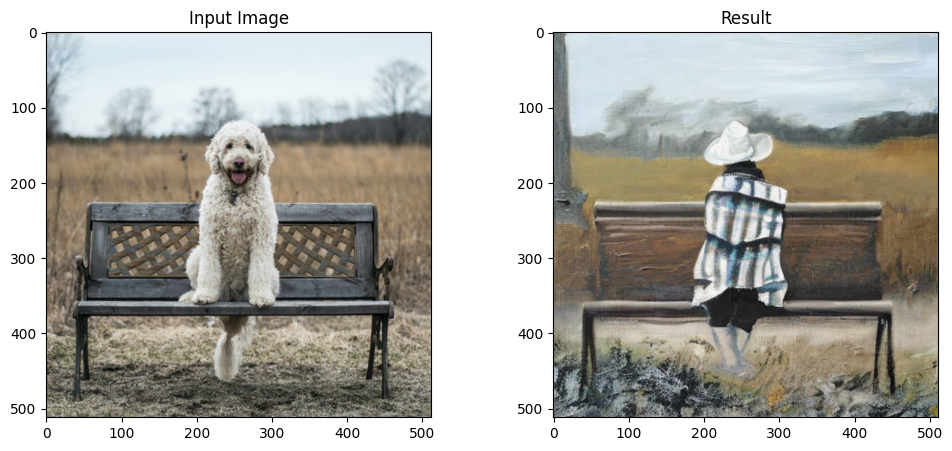

In [30]:
# Apply Img2Img
result_image = img2img_pipe(
    prompt="An oil painting of a man on a bench",
    image=init_image, # The starting image
    strength=0.6, # 0 for no change, 1.0 for max strength
).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(result_image);axs[1].set_title('Result');

## In-Painting

What if we wanted to keep some of the input image unchanged but generate something new in other parts? This is called ‘inpainting’.

To gain a deeper understanding of the inpainting process, let’s manually implement the logic behind the StableDiffusionInpaintPipelineLegacy. This approach will clarify how inpainting works at a lower level and provide insight into how Stable Diffusion processes inputs. Once we’ve completed this, we’ll explore the fine-tuned pipeline for comparison. Here’s how you can manually implement the inpainting pipeline and apply it to the example image and mask loaded in the ‘Setup’ section:

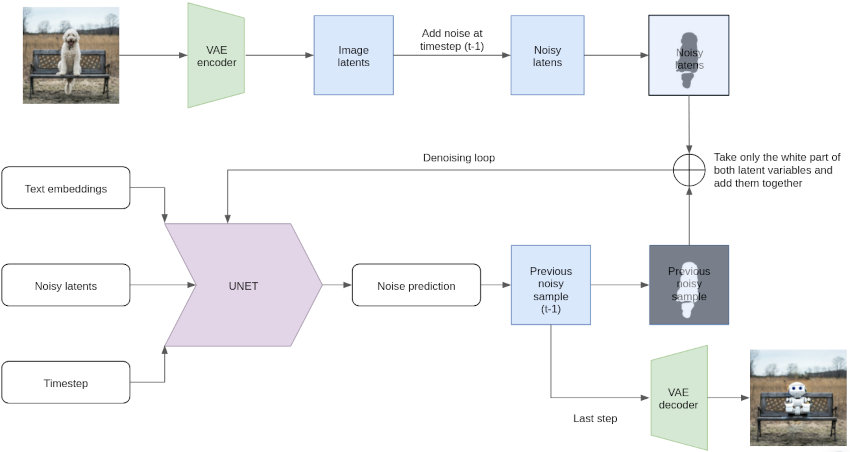

## A DIY Inpainting Loop


torch.Size([64, 64])

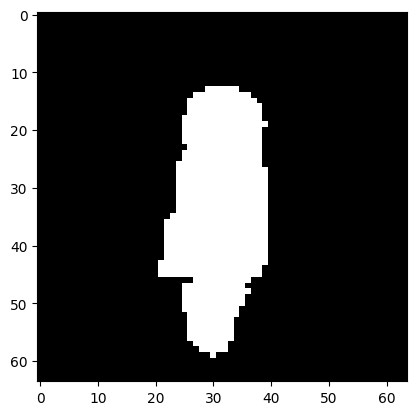

In [31]:
# Resize mask image
mask_image_latent_size = mask_image.resize((64,64))
mask_image_latent_size = torch.tensor( (np.array(mask_image_latent_size)[...,0] > 5).astype(np.float32) )
plt.imshow(mask_image_latent_size.numpy(), cmap='gray')

mask_image_latent_size = mask_image_latent_size.to(device)
mask_image_latent_size.shape

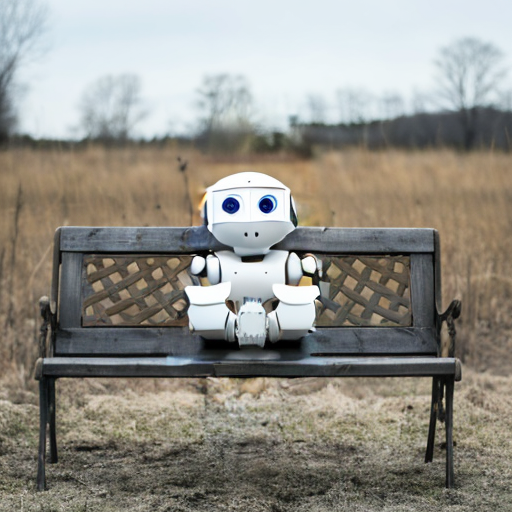

In [32]:
guidance_scale = 8
num_inference_steps = 30
prompt = "A small robot, high resolution, sitting on a park bench"
negative_prompt = "zoomed in, blurry, oversaturated, warped"
generator = torch.Generator(device=device).manual_seed(42)

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

for i, t in enumerate(pipe.scheduler.timesteps):
    # Expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2)
    # Apply any scaling required by the scheduler
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual with the UNet
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

    # Perform inpainting to fill in the masked areas
    if i < len(pipe.scheduler.timesteps)-1:
        # Add noise to the original image's latent at the previous timestep t-1
        noise = torch.randn(init_image_latents.shape, generator=generator, device=device, dtype=torch.float32)
        background = pipe.scheduler.add_noise(init_image_latents, noise, torch.tensor([pipe.scheduler.timesteps[i+1]]))

        latents = latents*mask_image_latent_size # white in the areas
        background = background * (1-mask_image_latent_size) # black in the areas

        # Combine the generated and original image latents based on the mask
        latents += background

# Decode latents
latents_norm = latents / pipe.vae.config.scaling_factor

with torch.no_grad():
    inpainted_image = pipe.vae.decode(latents_norm).sample

inpainted_image = (inpainted_image / 2 + 0.5).clamp(0, 1).squeeze()
inpainted_image = (inpainted_image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
inpainted_image = Image.fromarray(inpainted_image)

inpainted_image

## Inpainting Pipeline
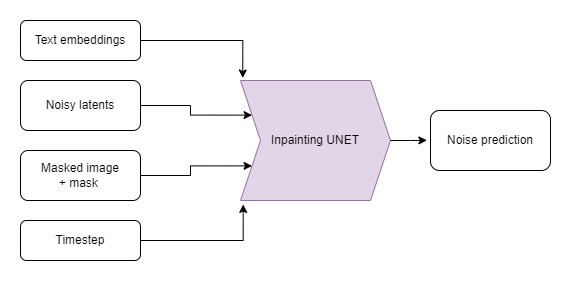

In [34]:
# Load the inpainting pipeline (requires a suitable inpainting model)
# pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting")

# "runwayml/stable-diffusion-inpainting" is no longer available.
# Therefore, we are using the "stabilityai/stable-diffusion-2-inpainting" model instead.
pipe = StableDiffusionInpaintPipeline.from_pretrained("sd2-community/stable-diffusion-2-inpainting")
pipe = pipe.to(device)

model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/372 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--sd2-community--stable-diffusion-2-inpainting/snapshots/5f74973cbb64c8568780732c17f43eb269d63a0d/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  0%|          | 0/50 [00:00<?, ?it/s]

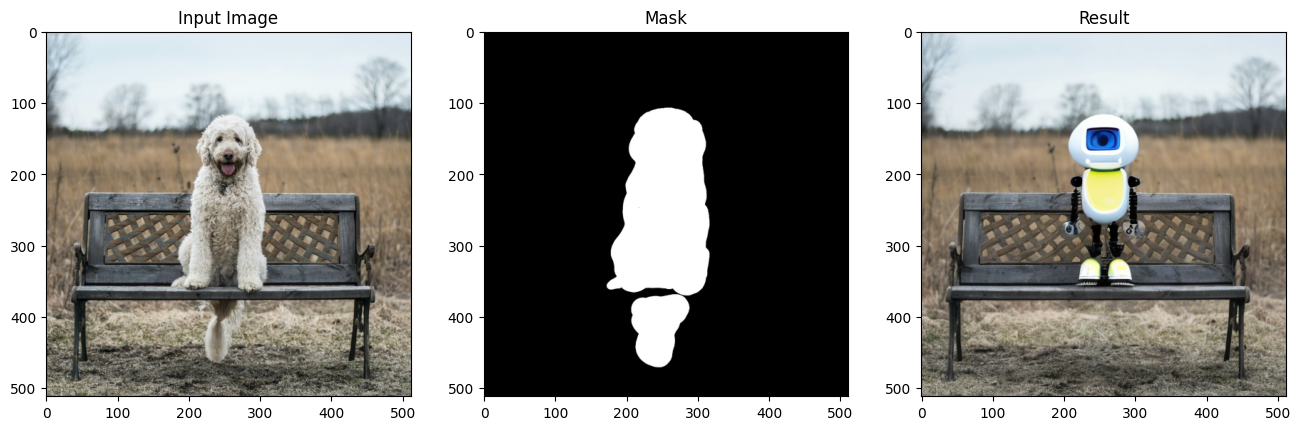

In [35]:
# Inpaint with a prompt for what we want the result to look like
prompt = "A small robot, high resolution, sitting on a park bench"
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

# View the result
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(mask_image);axs[1].set_title('Mask')
axs[2].imshow(image);axs[2].set_title('Result');

# Depth2Image
Img2Img is great, but sometimes we want to create a new image with the composition of the original but completely different colours or textures. It can be difficult to find an Img2Img strength that preserves what we’d like of the layout without also keeping the input colors.

Time for another fine-tuned model! This one takes in depth information as additional conditioning when generating. The pipeline uses a depth estimation model to create a depth map, which is then fed to the fine-tuned UNet when generating images to (hopefully) preserve the depth and structure of the initial image while filling in completely new content.



In [36]:
# Load the Depth2Img pipeline (requires a suitable model)
pipe = StableDiffusionDepth2ImgPipeline.from_pretrained("radames/stable-diffusion-2-depth-img2img")
pipe = pipe.to(device)

model_index.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/372 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--radames--stable-diffusion-2-depth-img2img/snapshots/1f29db1ac1f936db581fbfdabc28c7b99f292f09/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

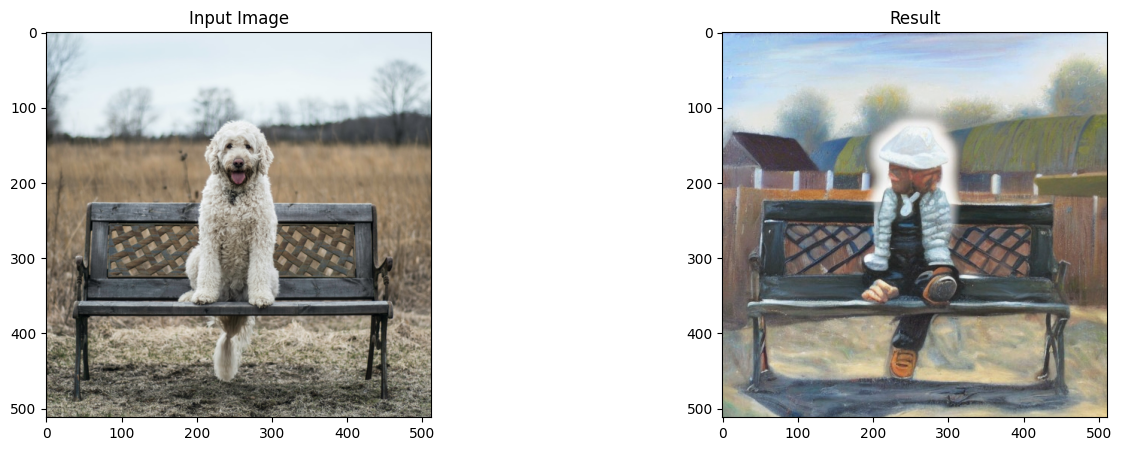

In [37]:
# Inpaint with a prompt for what we want the result to look like
prompt = "An oil painting of a man on a bench"
image = pipe(prompt=prompt, image=init_image).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(image);axs[1].set_title('Result');

Note how the output compares to the img2img example - here there is much more color variation, but the overall structure is still faithful to the original. This is not ideal in this case since the man has been given some extremely weird anatomy to match the dog shape, but in some cases this is extraordinarily useful.